In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from Attention import get_mask
from peft import PeftModel
import os
import matplotlib.pyplot as plt
import seaborn as sns

/Users/dam/miniforge3/envs/poemas/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

if torch.backends.mps.is_available():
    torch.mps.empty_cache()

device = torch.device("mps")
dtype = torch.float16

In [ ]:
BASE_MODEL = "/Users/dam/ESCOM/ML/Poemas/models/BASE_MODEL"
LORA_BASE_PATH = "/Users/dam/ESCOM/ML/Poemas/models/LoRa"

LORA_PATHS = {
    "aliteracion": os.path.join(LORA_BASE_PATH, "lora_aliteracion"),
    "anadiplosis": os.path.join(LORA_BASE_PATH, "lora_anadiplosis"),
    "anafora": os.path.join(LORA_BASE_PATH, "lora_anafora"),
    "animalizacion": os.path.join(LORA_BASE_PATH, "lora_animalizacion"),
    "asindeton": os.path.join(LORA_BASE_PATH, "lora_asindeton"),
    # "cosificacion": os.path.join(LORA_BASE_PATH, "lora_cosificacion"),
    "epifora": os.path.join(LORA_BASE_PATH, "lora_epifora"),
    "epiteto": os.path.join(LORA_BASE_PATH, "lora_epiteto"),
    "hiperbole": os.path.join(LORA_BASE_PATH, "lora_hiperbole"),
    "paralelismo": os.path.join(LORA_BASE_PATH, "lora_paralelismo"),
    #"personificacion": os.path.join(LORA_BASE_PATH, "lora_personificacion"),
    "pleonasmo": os.path.join(LORA_BASE_PATH, "lora_pleonasmo"),
    "polisindeton": os.path.join(LORA_BASE_PATH, "lora_polisindeton"),
    "simil": os.path.join(LORA_BASE_PATH, "lora_simil"),
    "metafora": os.path.join(LORA_BASE_PATH, "modelo_lora_final")
}

In [4]:
print(f"Tokenizer y Modelo Base desde {BASE_MODEL}")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, local_files_only=True)
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    dtype=dtype,
    device_map={"": "mps"},
    trust_remote_code=True,
    local_files_only=True,
    attn_implementation="eager"
)

Tokenizer y Modelo Base desde /Users/dam/ESCOM/ML/Poemas/models/BASE_MODEL


Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


In [5]:
print("adaptadores LoRA")
try:
    model = PeftModel.from_pretrained(model, LORA_PATHS["metafora"], adapter_name="metafora")

    for nombre, ruta in LORA_PATHS.items():
        if nombre != "metafora":
            model.load_adapter(ruta, adapter_name=nombre)

    model.config.output_attentions = True
    model.eval()
    print(f"Activos: {len(model.peft_config.keys())} # {model.peft_config.keys()}")
except Exception as e:
    print(f"Error en la carga de adaptadores: {e}")


adaptadores LoRA
Activos: 13 # dict_keys(['metafora', 'aliteracion', 'anadiplosis', 'anafora', 'animalizacion', 'asindeton', 'epifora', 'epiteto', 'hiperbole', 'paralelismo', 'pleonasmo', 'polisindeton', 'simil'])


In [6]:
def generar_poema(palabra, figura="metafora"):
    
    if figura in model.peft_config.keys():
        model.set_adapter(figura)
        prompt = f'Escribe un poema usando la figura retórica "{figura}" con la palabra "{palabra}".\nPoema:\n'
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=80,
                temperature=0.7,
                do_sample=True,
                repetition_penalty=1.1,
                pad_token_id=tokenizer.pad_token_id
            )
        resultado = tokenizer.decode(output[0], skip_special_tokens=True)
        poema = resultado.split("Poema:")[-1].strip()
        tag = "[LoRA]"
    else:
        poema = get_mask(palabra, figura)
        tag = "[LoRA]]"

    if poema:
        print(f"\n{tag} | {figura.upper()} -> {palabra}:\n{poema}\n" + "." * 30)
    else:
        print(f"Error: No se pudo obtener resultado para {figura}")


In [ ]:
def visualizar_atencion(palabra, figura="metafora", capa=-1, cabeza=0):
    if figura not in model.peft_config.keys():
        return

    model.set_adapter(figura)

    # Asegurar que la configuración de atención esté activa
    model.config.output_attentions = True

    prompt = f'Escribe un poema usando la figura retórica "{figura}" con la palabra "{palabra}".\nPoema:\n'
    inputs_prompt = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        # Generamos los tokens primero
        output_tokens = model.generate(
            **inputs_prompt,
            max_new_tokens=40,
            do_sample=True,
            temperature=0.7,
            use_cache=False # Desactivar cache es a veces necesario para obtener atenciones completas
        )

        # Realizamos un forward pass para obtener las atenciones de los tokens generados
        outputs = model(output_tokens, output_attentions=True, return_dict=True)
        attentions = outputs.attentions

    # Verificación de seguridad para evitar el TypeError
    if attentions is None:
        print("ERROR: El modelo no devolvió las matrices de atención. Revisa model.config.output_attentions.")
        return

    # Extraer la matriz (Capa, Lote, Cabeza, Seq_Logits, Seq_Logits)
    attn_matrix = attentions[capa][0, cabeza].detach().cpu().float().numpy()
    full_tokens = [tokenizer.decode([t]) for t in output_tokens[0]]

    plt.figure(figsize=(12, 10))
    sns.heatmap(attn_matrix, xticklabels=full_tokens, yticklabels=full_tokens, cmap='magma')
    plt.title(f"Atención: {figura.upper()} | {palabra}")
    plt.show()


[LoRA]] | ANTITESIS -> decepción:
En la esperanza, un jardín florece,
pero la decepción es el invierno que hiela.
La ilusión es el fuego que arde con pasión,
la desilusión, el hielo que apaga la emoción.
..............................

[LoRA] | ANIMALIZACION -> decepción:
en el bosque de la decepción, las hojas se desploman
y los árboles se inclinan bajo el peso de la mentira
la decepción es un río que fluye sin fin
y nos lleva a una orilla donde la verdad no existe
<|endoftext|>
..............................

[LoRA] | EPIFORA -> decepción:
En el silencio, escucho la decepción,
un eco que resuena con decepción,
la soledad me envuelve en decepción,
y mi corazón late con decepción.
<|endoftext|>
..............................

[LoRA]] | PERSONIFICACION -> decepción:
La noche se viste de luto y dolor,
La luna llora con lágrimas de plata y frío,
La decepción camina con paso de plomo y tristeza,
Y el viento suspira con un lamento de amor perdido.
..............................

[LoRA] | A

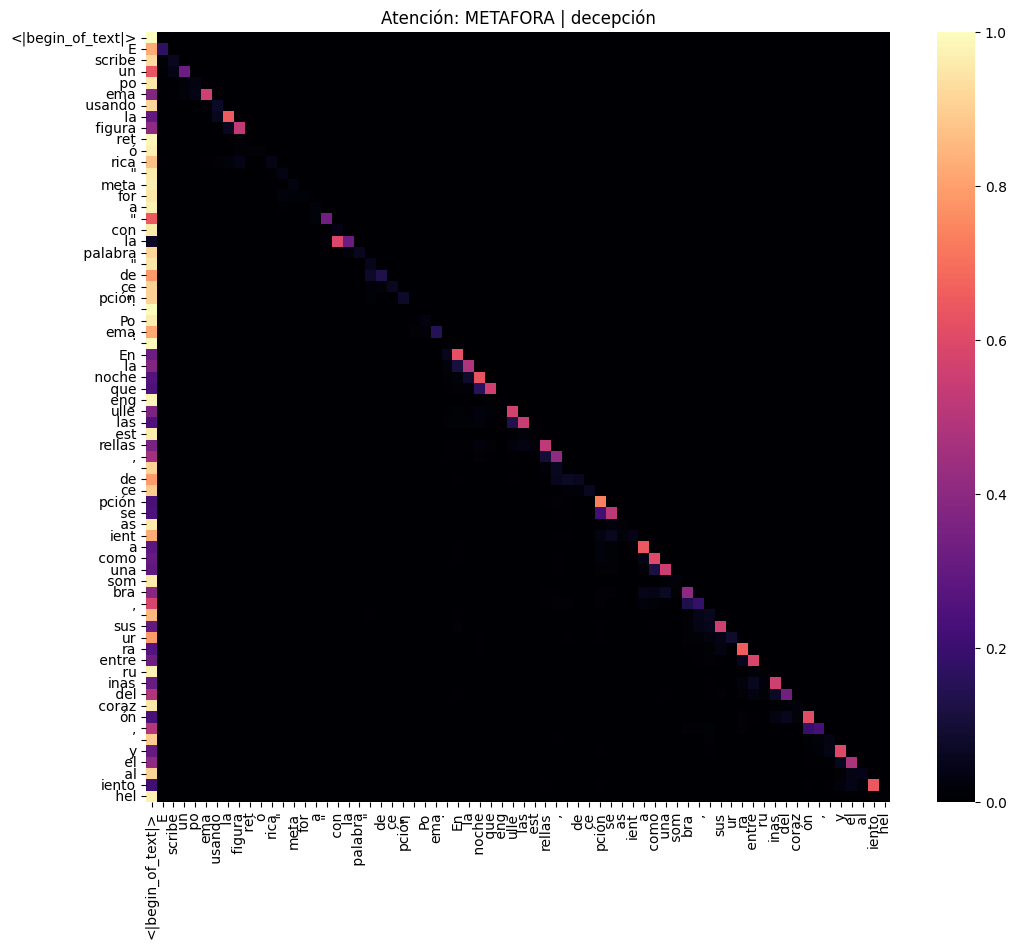

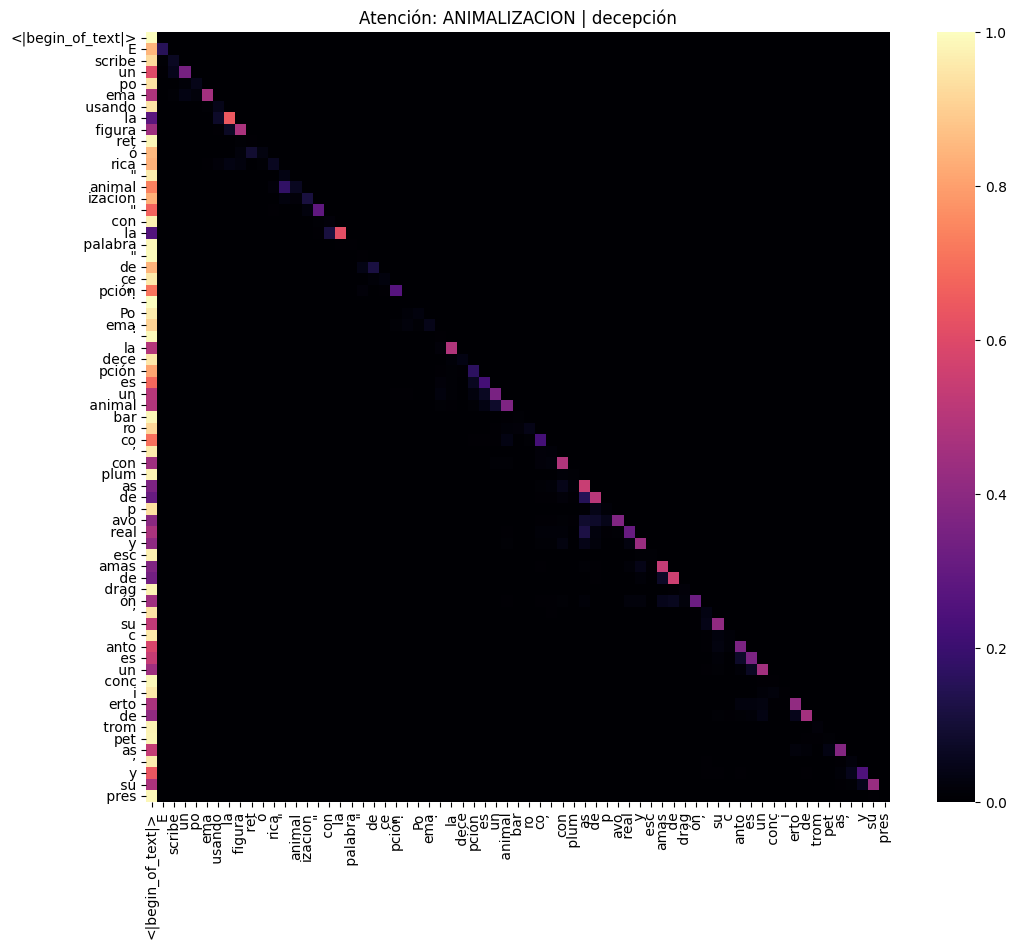

In [8]:
if __name__ == "__main__":

    test_palabra = "decepción"

    generar_poema(test_palabra, "antitesis")
    generar_poema(test_palabra, "animalizacion")
    generar_poema(test_palabra, "epifora")
    generar_poema(test_palabra, "personificacion")
    generar_poema(test_palabra, "aliteracion")
    generar_poema(test_palabra, "pleonasmo")

    generar_poema(test_palabra, "metafora")
    visualizar_atencion(test_palabra, "metafora")
    visualizar_atencion(test_palabra, "animalizacion")